# $H \rightarrow \rho\gamma, \phi\gamma$ Analysis

In [8]:
# Handling ROOT files
import json
import numpy as np
import uproot
import pandas as pd
import pickle
# Machine Learning
from sklearn.metrics import roc_curve
import xgboost as xgb # BDT
# Custom
from analysis import Analysis
from tools import GetData, CombineYears, ScaleByCol
from config import config
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

## Get BDT and 2016, 2017, and 2018 Data

In [9]:
# Dataframes
dfs_2016 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2016/v3-0-0/", verbose=False)
dfs_2017 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2017/v3-0-0/", verbose=False)
dfs_2018 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2018/v3-0-0/", verbose=False)
dataframes = CombineYears([dfs_2016, dfs_2017, dfs_2018], signal=config["signal"], verbose=True)

# BDT
bst = pickle.load(open("bdt.pkl", "r")) # BDT model
with open("features.json", "r") as fin:
    features = json.load(fin) # BDT training/testing features
x_test = pd.read_pickle("x_test.pkl", compression="gzip") # Test dataset
preds_test = bst.predict(xgb.DMatrix(x_test[features]))

Combining 4 dfs for wgamma
Combining 32 dfs for data
Combining 3 dfs for wjets
Combining 8 dfs for ttsl
Combining 6 dfs for ttg


## Prepare Data

In [10]:
# Scale relevant *_pt columns by Higgs mass
toScale = list(set(dataframes["data"].columns[dataframes["data"].columns.str.contains("_pt")])
               - set(["recoWLepton_pt", "met_pt"]))
dfs = ScaleByCol(dataframes, toScale, "recoHiggs_mass")

In [11]:
# Analysis object handles plots, making cuts, etc.
analysis = Analysis(config, dfs, bst, features, verbose=True)

# Drop rho or phi events
if config["analysis"] == "rho":
    analysis.MakeCut("genHiggsMeson_id==113 or name!='whiggs'")
elif config["analysis"] == "phi":
    analysis.MakeCut("genHiggsMeson_id==333 or name!='whiggs'")
    
# Make general cuts
sanity = "scale1fb > -999"
unblindedRegion = "(recoHiggs_mass<120 or recoHiggs_mass>130) or isData==0"
ptCuts = "(recoWLepton_pt>35 and abs(recoWLepton_id)==11) or (recoWLepton_pt>30 and abs(recoWLepton_id)==13)"
hem = "isHEM == 0"
gold = "isGold == 1"
filters = "passFilters == 1"
analysis.MakeCut([sanity, unblindedRegion, ptCuts, hem, gold, filters])

## Get BDT Predictions

In [12]:
# Get BDT predictions
analysis.Predict()
# Cut on BDT working point
window = ((x_test.recoHiggs_mass>110) | (x_test.recoHiggs_mass<140))
bestBDT = analysis.BestBDTCut(x_test, preds_test, window=window)
analysis.MakeBDTCut(bestBDT)

BDT working point: 0.704764783382
BDT efficiency: 225.688174059


# Results: Blinded

Created recoHiggs_mass stacked plot.


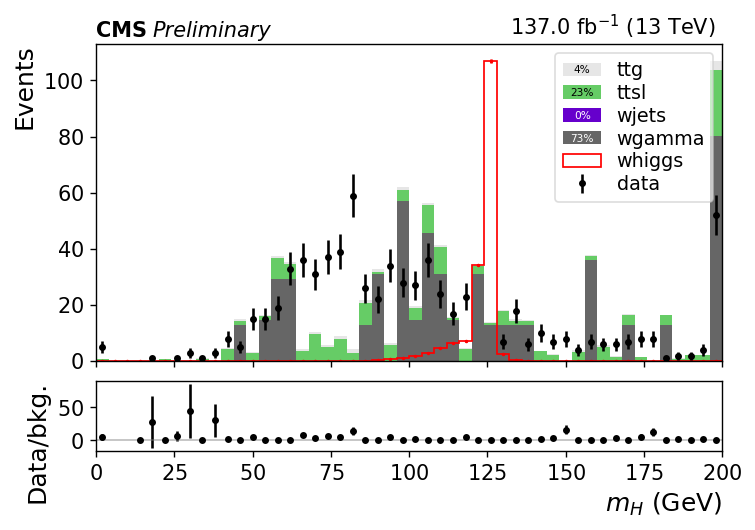

In [13]:
# Plots
analysis.Stacked("recoHiggs_mass", 50, 0, 200, xLabel=r"$m_{H}$ (GeV)", extra="_bdt", logY=False, save=False)

Created recoHiggs_mass stacked plot.


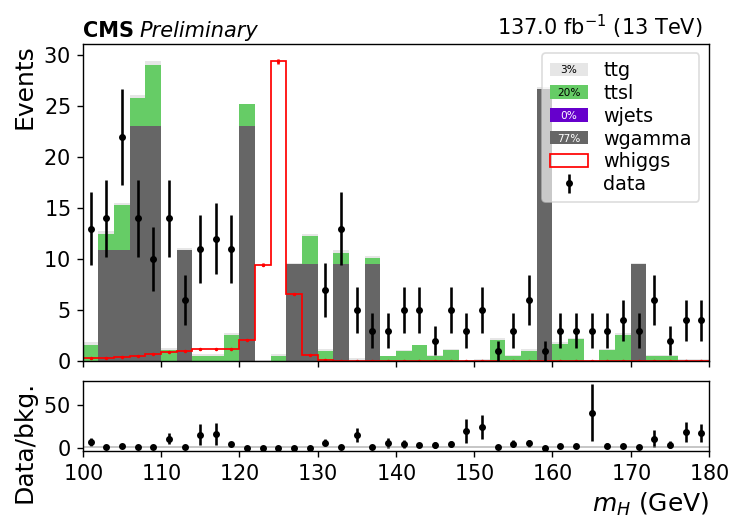

In [14]:
analysis.Stacked("recoHiggs_mass", 40, 100, 180, xLabel=r"$m_{H}$ (GeV)", extra="_bdtZoom", logY=False, 
                 overflow=False, save=False)